In [70]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import timm
from torchvision import transforms
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import numpy as np

In [71]:
# --- 2. CONFIGURATION ---
# Path based on your screenshot
DATA_ROOT = '/kaggle/input/leukemia/Original' 

BATCH_SIZE = 16
EPOCHS = 25        # Increased slightly for 4 classes
LR = 1e-4
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CLASSES = ['Benign','Early','Pre' ,'Pro'] # The 4 classes from your image

print(f"Device: {DEVICE}")

# --- 3. DATA PREPARATION & SPLITTING ---
print("--- Finding Files ---")
all_paths = []
all_labels = []

Device: cuda
--- Finding Files ---


In [72]:
# Map class names to numbers: Benign=0, Early=1, Pre=2, Pro=3
class_to_idx = {cls_name: i for i, cls_name in enumerate(CLASSES)}

for cls_name in CLASSES:
    cls_folder = os.path.join(DATA_ROOT, cls_name)
    # Get all images (handling jpg, png, jpeg)
    files = glob.glob(os.path.join(cls_folder, '*'))
    
    if len(files) == 0:
        print(f"WARNING: No files found in {cls_folder}. Check path?")
    
    for f in files:
        all_paths.append(f)
        all_labels.append(class_to_idx[cls_name])

print(f"Total Images Found: {len(all_paths)}")

Total Images Found: 3256


In [73]:
# Split: 70% Train, 15% Val, 15% Test
# First, split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)

# Then split Temp (30%) into Val (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Split Results: Train={len(X_train)} | Val={len(X_val)} | Test={len(X_test)}")

Split Results: Train=2279 | Val=488 | Test=489


In [74]:
# --- 4. RAM-CACHED DATASET ---
class CachedDataset(Dataset):
    def __init__(self, file_paths, labels, img_size, mode="train"):
        self.data = []
        self.labels = labels
        self.mode = mode
        
        # Define Transforms
        self.resize = transforms.Resize((img_size, img_size))
        
        # Augmentation for Training only
        if mode == "train":
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(), # Simple augmentation
                transforms.RandomRotation(10),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        print(f"Loading {mode} set ({len(file_paths)} images) into RAM...")
        for img_path in tqdm(file_paths, desc=f"Caching {mode}"):
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                # Resize immediately to save RAM
                self.data.append(self.resize(img))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        return self.transform(img), torch.tensor(self.labels[idx], dtype=torch.long)

In [75]:
# Create Datasets
train_ds = CachedDataset(X_train, y_train, IMG_SIZE, mode="train")
val_ds = CachedDataset(X_val, y_val, IMG_SIZE, mode="val")
test_ds = CachedDataset(X_test, y_test, IMG_SIZE, mode="test")

# Create Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Loading train set (2279 images) into RAM...


Caching train:   0%|          | 0/2279 [00:00<?, ?it/s]

Loading val set (488 images) into RAM...


Caching val:   0%|          | 0/488 [00:00<?, ?it/s]

Loading test set (489 images) into RAM...


Caching test:   0%|          | 0/489 [00:00<?, ?it/s]

In [62]:
# --- 5. MODEL SETUP ---
def build_model():
    # num_classes=4 because we have Benign, Early, Pre, Pro
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=4)
    return model.to(DEVICE)

model = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

# --- 6. TRAINING LOOP ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for inputs, targets in loop:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        loop.set_postfix(acc=100.*correct/total)
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Validation
    model.eval()
    val_loss_accum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss_accum += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            
    val_loss = val_loss_accum / len(val_loader)
    val_acc = 100. * val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Ep {epoch+1} | T.Loss: {train_loss:.4f} | V.Loss: {val_loss:.4f} | V.Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'swin_4class_best.pth')

print(f"\nTraining Complete. Best Val Accuracy: {best_acc:.2f}%")


Starting Training...


Epoch 1/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 1 | T.Loss: 0.9255 | V.Loss: 0.5732 | V.Acc: 75.00%


Epoch 2/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 2 | T.Loss: 0.5958 | V.Loss: 0.5608 | V.Acc: 74.59%


Epoch 3/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 3 | T.Loss: 0.5301 | V.Loss: 0.5812 | V.Acc: 77.66%


Epoch 4/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 4 | T.Loss: 0.5178 | V.Loss: 0.4896 | V.Acc: 81.15%


Epoch 5/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 5 | T.Loss: 0.4714 | V.Loss: 0.4900 | V.Acc: 82.38%


Epoch 6/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 6 | T.Loss: 0.4983 | V.Loss: 0.3998 | V.Acc: 85.04%


Epoch 7/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 7 | T.Loss: 0.3669 | V.Loss: 0.3400 | V.Acc: 87.91%


Epoch 8/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 8 | T.Loss: 0.3547 | V.Loss: 0.3040 | V.Acc: 89.14%


Epoch 9/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 9 | T.Loss: 0.3164 | V.Loss: 0.3060 | V.Acc: 89.75%


Epoch 10/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 10 | T.Loss: 0.2554 | V.Loss: 0.2455 | V.Acc: 92.21%


Epoch 11/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 11 | T.Loss: 0.2302 | V.Loss: 0.1753 | V.Acc: 94.67%


Epoch 12/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 12 | T.Loss: 0.1879 | V.Loss: 0.1444 | V.Acc: 96.11%


Epoch 13/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 13 | T.Loss: 0.1544 | V.Loss: 0.1322 | V.Acc: 95.08%


Epoch 14/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 14 | T.Loss: 0.1339 | V.Loss: 0.1428 | V.Acc: 96.11%


Epoch 15/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 15 | T.Loss: 0.1331 | V.Loss: 0.1212 | V.Acc: 95.90%


Epoch 16/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 16 | T.Loss: 0.1143 | V.Loss: 0.0854 | V.Acc: 96.93%


Epoch 17/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 17 | T.Loss: 0.1335 | V.Loss: 0.1433 | V.Acc: 95.70%


Epoch 18/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 18 | T.Loss: 0.1040 | V.Loss: 0.1825 | V.Acc: 94.26%


Epoch 19/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 19 | T.Loss: 0.1067 | V.Loss: 0.1394 | V.Acc: 95.29%


Epoch 20/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 20 | T.Loss: 0.1222 | V.Loss: 0.0685 | V.Acc: 97.54%


Epoch 21/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 21 | T.Loss: 0.1007 | V.Loss: 0.0716 | V.Acc: 97.34%


Epoch 22/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 22 | T.Loss: 0.0765 | V.Loss: 0.0812 | V.Acc: 96.72%


Epoch 23/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 23 | T.Loss: 0.0970 | V.Loss: 0.1020 | V.Acc: 97.13%


Epoch 24/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 24 | T.Loss: 0.0801 | V.Loss: 0.1025 | V.Acc: 96.72%


Epoch 25/25:   0%|          | 0/143 [00:00<?, ?it/s]

Ep 25 | T.Loss: 0.0841 | V.Loss: 0.0625 | V.Acc: 98.16%

Training Complete. Best Val Accuracy: 98.16%


In [63]:
# --- Save the Final Model (Last Epoch) ---
torch.save(model.state_dict(), 'swin_4class_final.pth')
print("Final model weights saved to 'swin_4class_final.pth'")

Final model weights saved to 'swin_4class_final.pth'


In [64]:
# --- 7. FINAL TEST EVALUATION ---
print("\n--- Running Final Test Set Evaluation ---")
model.load_state_dict(torch.load('swin_4class_best.pth'))
model.eval()

test_correct = 0
test_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print(f"Final Test Accuracy: {100. * test_correct / test_total:.2f}%")


--- Running Final Test Set Evaluation ---


Testing:   0%|          | 0/31 [00:00<?, ?it/s]

Final Test Accuracy: 96.73%


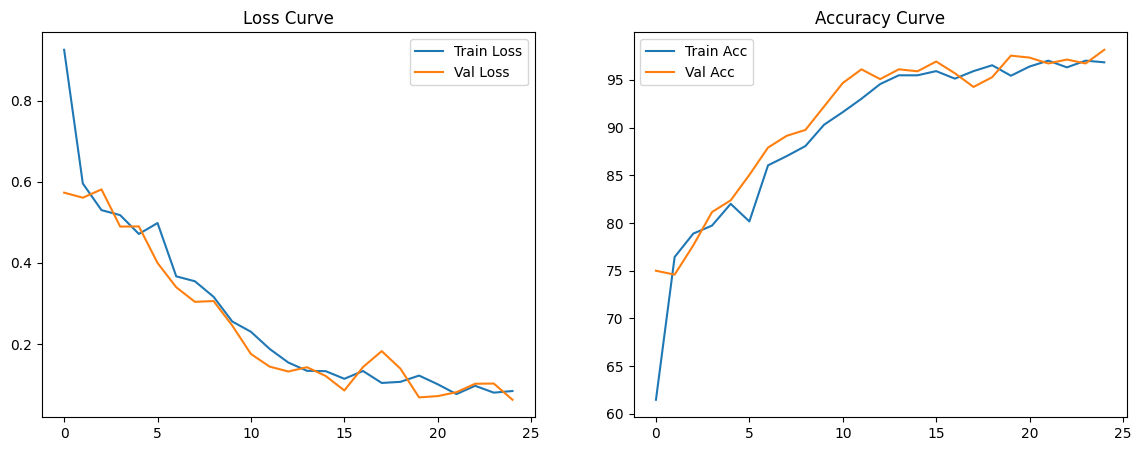

In [65]:
# --- 8. PLOTTING ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title('Loss Curve')
ax[0].legend()

ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc')
ax[1].set_title('Accuracy Curve')
ax[1].legend()
plt.show()

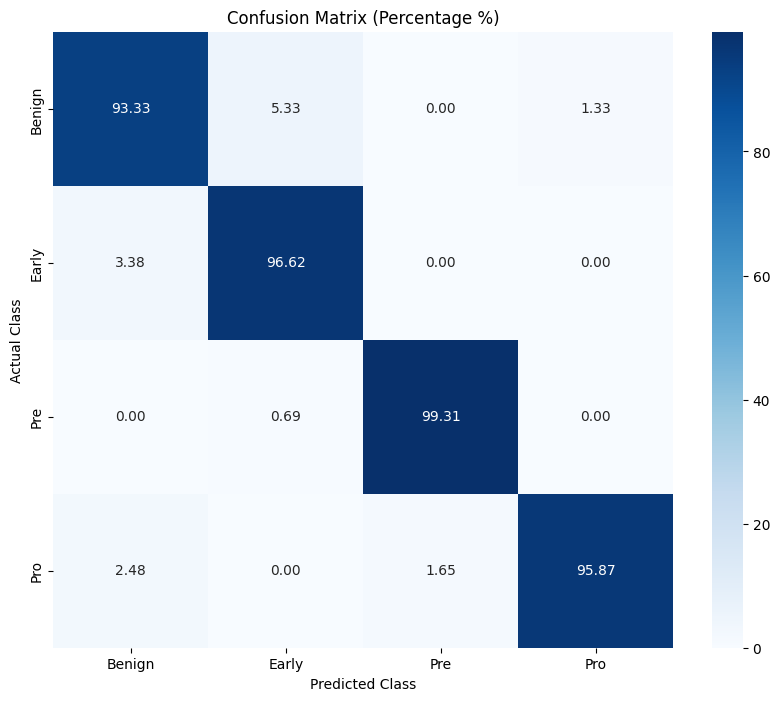

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate the standard Confusion Matrix (Counts)
cm = confusion_matrix(all_targets, all_preds)

# 2. Convert to Percentages (Row-Wise Normalization)
# We divide each value by the sum of its row (Actual Class Total)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)

# Add labels to make it clear
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (Percentage %)')
plt.show()


Running t-SNE...
Extracting features from validation set...
Final Feature Shape: (488, 768)


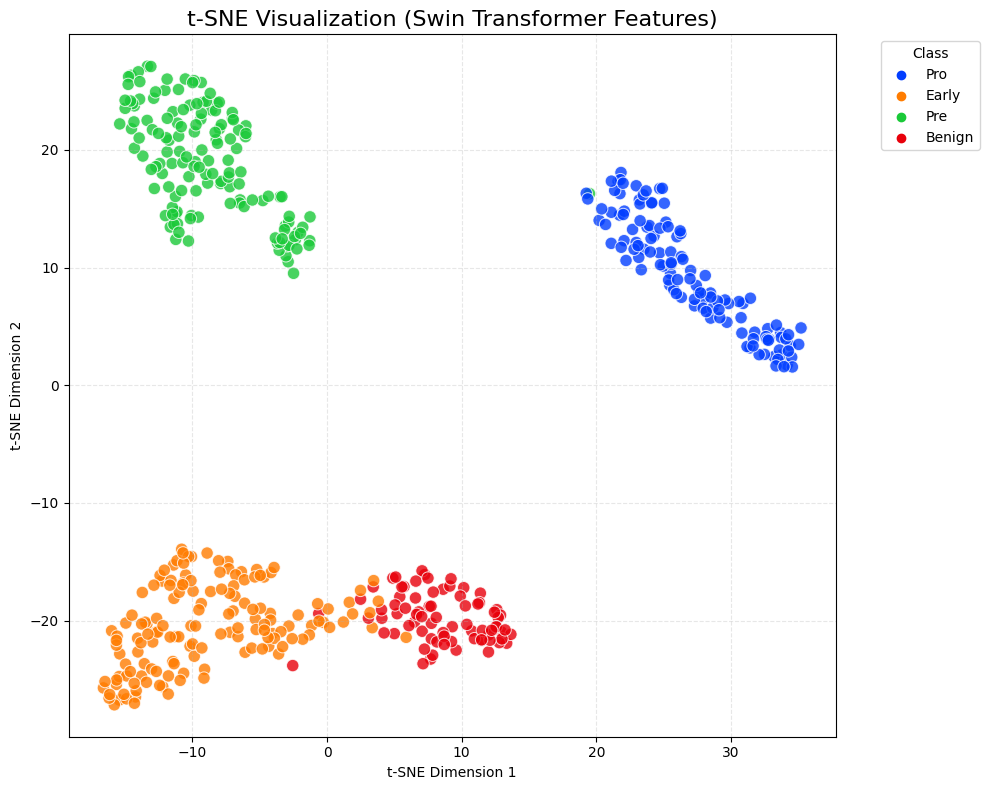

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

# ==========================================
# 7. t-SNE VISUALIZATION (Fixed for Swin)
# ==========================================
print("\nRunning t-SNE...")

# 1. SETUP FEATURE EXTRACTOR
original_head = model.head 
model.head = nn.Identity() 

model.eval()
all_features = []
all_labels = []

print("Extracting features from validation set...")
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        
        # Swin Output Shape: [Batch, H, W, C] (e.g., [32, 7, 7, 768])
        features = model(inputs)
        
        # --- FIX: Apply Global Average Pooling ---
        # If output is 4D, we pool spatial dims to get [Batch, C]
        if features.ndim == 4:
            # Swin (timm) typically outputs (B, H, W, C), so we mean over dim 1 and 2
            # If your model outputs (B, C, H, W), change to dim=(2, 3)
            features = features.mean(dim=(1, 2)) 
        
        # Now shape is [Batch, 768] (Flat vector)
        all_features.append(features.cpu().numpy())
        all_labels.append(targets.numpy())

# Restore head
model.head = original_head

# 2. PREPARE DATA
X_feats = np.concatenate(all_features, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# Double check shape (should be 2D now)
print(f"Final Feature Shape: {X_feats.shape}")
# If it's still not 2D for some reason, force flatten it:
if X_feats.ndim > 2:
    X_feats = X_feats.reshape(X_feats.shape[0], -1)

# 3. COMPUTE t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_feats)

# 4. PLOT RESULTS
class_names = ['Benign', 'Early', 'Pre', 'Pro'] # Update to match your actual classes
y_true_names = [class_names[i] for i in y_true]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded[:, 0], 
    y=X_embedded[:, 1], 
    hue=y_true_names, 
    palette='bright', 
    s=80, 
    alpha=0.8
)

plt.title('t-SNE Visualization (Swin Transformer Features)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
import torch
import os

# --- Define explicit path to Kaggle Output Directory ---
save_path = '/kaggle/working/swin_transformer_fl_weights.pth'

# --- Save the weights ---
torch.save(model.state_dict(), save_path)

print(f"✅ Model weights saved successfully to: {save_path}")

# --- Verify the file exists ---
if os.path.exists(save_path):
    file_size = os.path.getsize(save_path) / (1024 * 1024)
    print(f"   File Size: {file_size:.2f} MB")
    
    print("\n📂 Content of /kaggle/working/:")
    print(os.listdir("/kaggle/working"))

✅ Model weights saved successfully to: /kaggle/working/swin_transformer_fl_weights.pth
   File Size: 105.06 MB

📂 Content of /kaggle/working/:
['swin_4class_final.pth', '.virtual_documents', 'swin_4class_best.pth', 'swin_transformer_fl_weights.pth']
